In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Image Processing with Neural Network
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [ ]:
###-----------------
### Import Libraries
###-----------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, ConfusionMatrixDisplay
# from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_labels


# %matplotlib inline

In [ ]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'students_base_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 190
IMG_WIDTH = 190

# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1)
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [ ]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print (physical_devices)
else:
    print ('Error: No GPU device found')

Error: No GPU device found


## Helper Functions
**Note** all helper functions have been moved to util.helper

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [ ]:
# '''
#     For reading from web link
# '''

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir+'/flower_photos')
# '''
#     For reading from local directory
# '''
# data_dir = os.path.join(inpDir, subDir)

In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos/flower_photos')

In [ ]:
# list content of data_dir
os.listdir(data_dir)

['daisy', 'tulips', 'sunflowers', 'dandelion', 'roses', 'LICENSE.txt']

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


In [ ]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):

    # iterate through the batch
    for i in range(BATCH_SIZE):

        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure

        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8"))

        # display class in the title
        ax.set_title(class_names[labels[i]])

# fit the subplot(s) in to the figure area
plt.tight_layout()

# display all open images
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# how many examples in each of the class

def fn_plot_label(train_df, test_df):

  fig, axes = plt.subplots(1,2, figsize=(10, 5)) # Create a figure and a 1x2 grid of axes

  # Plot on the first subplot (index 0 in the axes array)
  train_df['label'].value_counts().plot(
      kind='bar', title = 'Train Distribution', color= 'DarkBlue', alpha=0.7, ax=axes[0])

  # Plot on the second subplot (index 1 in the axes array)
  test_df['label'].value_counts().plot(
      kind='bar', title = 'Test Distribution', color= 'Orange', alpha=0.7, ax=axes[1])

  plt.tight_layout() # Adjust layout to prevent overlap
  plt.show() # Display the plot

# Extract labels from the datasets
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

test_labels = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())

# Create pandas Series from the labels
train_labels_series = pd.Series(train_labels, name='label')
test_labels_series = pd.Series(test_labels, name='label')

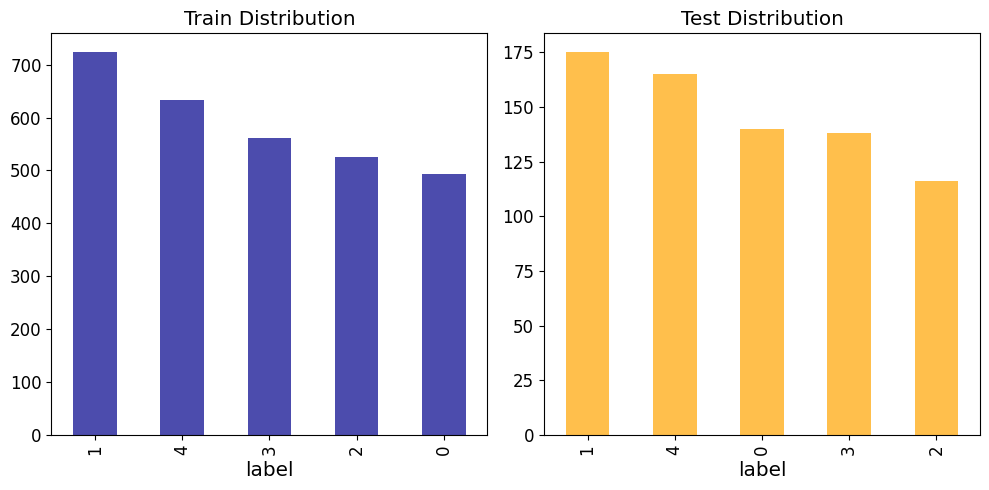

In [ ]:
# how many examples in each of the class
# fn_plot_label(train_ds, test_ds) # This line caused the error

# Instead, use the pandas Series created in the previous cell
fn_plot_label(pd.DataFrame({'label': train_labels_series}), pd.DataFrame({'label': test_labels_series}))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
activation = 'relu'
optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def build_model(input_shape, num_classes):

    ###-----------------------
    ### Define your model here
    ###-----------------------
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = input_shape))       # this layer is initializing the input shape
    model.add(tf.keras.layers.Rescaling(1./255.))        # scaling the data

    ### ------
    ### Set 1
    ### ------
    model.add(tf.keras.layers.Conv2D(32, 3,
                                     kernel_initializer= initializer,
                                     activation = activation))    # (188 x 188 x 32)
    model.add(tf.keras.layers.MaxPool2D(2,2))             # (94 x 94 x 32 )


    ### ------
    ### Set 2
    ### ------
    model.add(tf.keras.layers.Conv2D(64, 3, kernel_initializer= initializer,
                                     activation = activation))      # (92 x 92 x 64)
    model.add(tf.keras.layers.MaxPool2D(2,2))                 # (46 x 46 x 64)

    ### ------
    ### Set 3
    ### ------
    model.add(tf.keras.layers.Conv2D(128, 3, kernel_initializer= initializer,
                                     activation = activation))      # (44 x 44 x 128)
    model.add(tf.keras.layers.MaxPool2D(2,2))                 # (22 x 22 x 128)

    ### ------
    ### Set 4
    ### ------
    model.add(tf.keras.layers.Conv2D(256, 3, kernel_initializer= initializer,
                                     activation = activation))      # (20 x 20 x 256)
    model.add(tf.keras.layers.MaxPool2D(2,2))                 # (10 x 10 x 256)


    ### ------
    ### Set 5
    ### ------
    model.add(tf.keras.layers.Conv2D(512, 3, kernel_initializer= initializer,
                                     activation = activation))      # (8 x 8 x 512)
    model.add(tf.keras.layers.MaxPool2D(2,2))                 # (4 x 4 x 512)


    ### ------
    ### Set 6
    ### ------
    model.add(tf.keras.layers.Conv2D(1024, 3, kernel_initializer= initializer,
                                     activation = activation))      # (2 x 2 x 1024)

    ### ------
    ### Head
    ### ------
    model.add(tf.keras.layers.Flatten())       # 2048

    # First Dense
    model.add(tf.keras.layers.Dense(64, kernel_initializer= initializer))

    # Output Layer
    model.add(tf.keras.layers.Dense(10 , kernel_initializer= initializer))

    return model

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_model(input_shape, num_classes)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 190, 190, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 188, 188, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,551,050 (24.99 MB)

 Trainable params: 6,551,050 (24.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss = loss_fn,
              optimizer=optimizer,
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 2)

Epoch 1/100
92/92 - 463s - 5s/step - accuracy: 0.3263 - loss: 1.5521 - val_accuracy: 0.4305 - val_loss: 1.2695
Epoch 2/100
92/92 - 468s - 5s/step - accuracy: 0.5163 - loss: 1.1447 - val_accuracy: 0.4986 - val_loss: 1.2613
Epoch 3/100
92/92 - 424s - 5s/step - accuracy: 0.6025 - loss: 0.9796 - val_accuracy: 0.5763 - val_loss: 1.0989
Epoch 4/100
92/92 - 424s - 5s/step - accuracy: 0.6553 - loss: 0.8727 - val_accuracy: 0.6635 - val_loss: 0.9065
Epoch 5/100
92/92 - 449s - 5s/step - accuracy: 0.6768 - loss: 0.8294 - val_accuracy: 0.6567 - val_loss: 0.8886
Epoch 6/100
92/92 - 423s - 5s/step - accuracy: 0.7084 - loss: 0.7415 - val_accuracy: 0.6621 - val_loss: 0.9025
Epoch 7/100
92/92 - 424s - 5s/step - accuracy: 0.7357 - loss: 0.6821 - val_accuracy: 0.6390 - val_loss: 0.9799
Epoch 8/100
92/92 - 427s - 5s/step - accuracy: 0.7742 - loss: 0.5901 - val_accuracy: 0.6608 - val_loss: 1.0527
Epoch 9/100
92/92 - 423s - 5s/step - accuracy: 0.7834 - loss: 0.5663 - val_accuracy: 0.6649 - val_loss: 1.1049
E

In [ ]:
def fn_plot_tf_hist(hist_df):

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    # print(best)

    props = dict(boxstyle = 'round', facecolor = 'aqua', alpha = 0.4)
    facecolor = 'cyan'
    fontsize = 12
    CMAP = plt.cm.coolwarm
    ax = axes[0]

    hist_df.plot(y=[y2,y4], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y2].min(), hist_df.iloc[-1][y4])


    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Min : {best[y4].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy()[0], best[y4].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy()[0], best[y4].to_numpy()[0] + offset),   #end
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy()[0], color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())

    ax.grid()


    ax = axes[1]
    hist_df.plot(y=[y1,y3], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y1], hist_df.iloc[-1][y3])

    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Best : {best[y3].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0] + offset),
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy(), color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y1.capitalize())

    ax.grid()
    plt.suptitle('Training Perfromance')
    plt.tight_layout()
    plt.show()
    # ax = axes[1]
    # hist_df.plot(y=[y2,y4], ax=axes[0])
    # hist_df.plot(y=[y1,y3], ax=ax)

In [ ]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [ ]:
y_train = tf.concat([y for x, y in train_ds], axis=0).numpy()
y_hat = model.predict(train_ds)
y_pred = y_hat.argmax(axis=1)



In [ ]:
y_pred = []
y_train = []
for x, y in train_ds:
  y_hat = model.predict(x)
  y_pred.extend(y_hat.argmax(axis=1))


In [ ]:
print(f'Accuracy : {accuracy_score(y_train, y_pred)}')

print(classification_report(y_train, y_pred))

print(f1_score(y_train, y_pred, average = 'weighted'))

fn_plot_consusion_matrix(y_train, y_pred)

### Reload best Weights for evaluation

### Evaluate the model

## Validate on the validation set

In [ ]:
data_dir = os.path.join(inpDir, valDir)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    #subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots
i = 0
# take one batch of the dataset
for images, labels in valid_ds.take(1):

    # iterate through the batch
    for i in range(BATCH_SIZE):

        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure

        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8"))

        # display class in the title
        ax.set_title(class_names[labels[i]])

# fit the subplot(s) in to the figure area
plt.tight_layout()

# display all open images
plt.show()

In [ ]:
loss, acc = new_model.evaluate(valid_ds)

print('Accuracy score on Validation Data : {:.3f}%'.format( acc*100))

In [ ]:
for images, labels in valid_ds.take(2 ):

    # Predict again to keep y_pred in synch with the images
    yhat = new_model.predict(images, verbose = 0)

    y_pred = yhat.argmax(axis = 1)
    fontsize = 12
    fig = plt.figure()  # figure with default size in inches

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

    for i in range ( BATCH_SIZE ):

        if labels.numpy()[i]!= y_pred[i]:
            fc = 'purple'
            ec="red"
            text_color = 'yellow'
        else:
            fc = 'cyan'
            ec = 'blue'
            text_color = 'blue'

        props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec = ec)

        ax = fig.add_subplot(BATCH_SIZE // 8 , 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure

        ax.imshow ( images[i].numpy().astype( "uint8" ) )

        ax.text(0.1, 0.95, class_names[y_pred[i]], transform=ax.transAxes,
                fontsize=fontsize, color = text_color,
            verticalalignment='top', bbox=props)   # add number (class) of the image


        ax.set_title(class_names[labels.numpy()[i]])
        #ax.set_title('{} \n {}'.format( class_names[labels.numpy()[i]], ))

        ax.axis("off")

    plt.tight_layout()

    plt.show()